# 9.0 — Backtest d'options (straddle ATM 21j, delta-hedgé)

**But :** comparer EWM / HAR / LSTM / Blend via un backtest d’options "straddle ATM" (call+put), maturité ~21 jours, pricing "Black–Scholes", delta-hedging quotidien.  

In [25]:
from pathlib import Path
if "__file__" not in globals():
    __file__ = str((Path.cwd() / "dummy" / "06_backtest_options.py").resolve())


### 9.1 Imports, chemins et configuration du backtest options

**Explication :**  
1) On fixe la constante "TRADING_DAYS = 252" (nombre de jours de bourse/an), utile pour passer du quotidien à l’annualisé et inversement.

**Pourquoi nous avons fait cela :**  
1) La constante 252 garantit une **cohérence d’échelle** des volatilités dans tout le pipeline.  


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm, ttest_rel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

PROJECT_ROOT = Path(__file__).resolve().parents[1]
PROC_DIR = PROJECT_ROOT / "data" / "processed"
LSTM_DIR = PROJECT_ROOT / "data" / "models" / "lstm"
HAR_DIR  = PROJECT_ROOT / "data" / "models" / "har_rv"
OUT_DIR  = PROJECT_ROOT / "data" / "backtests" / "options"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRADING_DAYS = 252


### 9.2 Données sous-jacentes SPX 

**Explication :**  
1) Charge les données prétraitées du SPX depuis le fichier parquet et les trie par date.  
2) Sélectionne la colonne de prix de clôture "close_^gspc"` si présente, sinon une autre colonne contenant "close".  
3) Récupère la série des rendements journaliers (ret_d).  
4) Calcule la volatilité exponentielle pondérée (EWM, λ=0.94) en pourcentage et la renomme "ewm_base" pour éviter les conflits de noms.  
5) Retourne un DataFrame contenant : date, px (prix), ret (rendement) et ewm_base.  

**Pourquoi nous avons fait cela :**  
1) Préparer un jeu de données propre (prix, rendements, baseline de volatilité) pour le backtest d’options.  
2) Harmoniser les noms de colonnes (ewm_base) afin d’éviter des conflits lors des fusions avec d’autres modèles (HAR, LSTM).  
3) Garantir que toutes les séries soient alignées dans un DataFrame unique avec suppression des NaN, facilitant leur utilisation ultérieure.  



In [27]:
def load_spx():
    df = pd.read_parquet(PROC_DIR / "spx_index_features.parquet").sort_values("date").reset_index(drop=True)
    px = df["close_^gspc"].astype(float) if "close_^gspc" in df.columns else df.filter(regex="close", axis=1).iloc[:, 0]
    ret = df["ret_d"].astype(float)
    ewm_base = df["vol_ewm_094"].astype(float) * 100.0  # %
    return pd.DataFrame({"date": df["date"], "px": px, "ret": ret, "ewm_base": ewm_base}).dropna()


### 9.3 Prévisions LSTM + HAR 

**Explication :**  
1) Détermine le nom de base du fichier LSTM en fonction de la cible choisie :  
   - sigma1 → fichier LSTM des prévisions à 1 jour.  
   - vol5f → fichier LSTM des prévisions à 5 jours.  
2) Charge les prévisions LSTM  et HAR-RV.  
3) Fusionne les deux DataFrames sur la colonne date pour aligner les prévisions.  
4) Renomme les colonnes pour uniformiser les noms :  
   - y_lstm → lstm  
   - y_blend → blend  
   - y_ewm → ewm_csv  
   - y_pred_har → har  
5) Retourne un DataFrame final contenant les prévisions alignées pour la comparaison.  

**Pourquoi nous avons fait cela :**  
1) Centraliser toutes les prévisions (LSTM, HAR, blend, EWM) dans un même DataFrame pour faciliter les backtests.  
2) Harmoniser les noms de colonnes permet d’éviter les ambiguïtés lors des analyses comparatives.  
3) Aligner temporellement LSTM et HAR garantit une comparaison cohérente et juste des modèles.  

In [28]:
def load_forecasts(target_name="vol5f"):
    base = "lstm_target_sigma1_enriched_log" if target_name == "sigma1" else "lstm_target_vol5f_enriched_log"
    lstm = pd.read_csv(LSTM_DIR / f"{base}_test.csv", parse_dates=["date"])
    har  = pd.read_csv(HAR_DIR  / f"har_{target_name}_test.csv", parse_dates=["date"])
    df = lstm.merge(har[["date", "y_pred_har"]], on="date", how="inner")
    df = df.rename(columns={"y_lstm": "lstm", "y_blend": "blend", "y_ewm": "ewm_csv", "y_pred_har": "har"})
    return df


### 9.4 Pricing Black–Scholes du straddle ATM 

**Explication :**  
1) Implémente la formule de Black–Scholes pour calculer le prix d’un straddle ATM (call + put).  
2) sigma est fourni en volatilité annualisée en %, convertie en décimal.  
3) Cas particulier : si la maturité : T ≤ 0, on renvoie la valeur intrinsèque (max payoff) et le delta total associé.  
4) Sinon, on calcule :  
   - d1, d2 selon Black–Scholes.  
   - Probabilités cumulées Nd1, Nd2 via la loi normale.  
   - Prix du call et du put.  
   - Deltas du call et du put, puis somme pour le straddle.  
5) Retourne un tuple : prix du straddle et delta total.  

**Pourquoi nous avons fait cela :**  
1) Le straddle ATM est une stratégie classique pour tester la qualité d’une prévision de volatilité, il est sensible uniquement à σ.  
2) La formule de Black–Scholes permet de convertir une prévision de volatilité en valeur d’option, ce qui donne une validation économique du modèle.  
3) Le delta total est nécessaire pour simuler le delta-hedging du straddle dans le backtest.  



In [29]:
def bs_straddle(S, K, T, sigma, r=0.0):
    """Retourne (prix du straddle, delta total du straddle) avec sigma en % annualisée."""
    sig = max(1e-4, sigma / 100.0)
    if T <= 0:
        call = max(0.0, S - K)
        put  = max(0.0, K - S)
        delta_c = 1.0 if S > K else 0.0
        delta_p = -1.0 if S < K else 0.0
        return call + put, delta_c + delta_p
    d1 = (log(S / K) + (r + 0.5 * sig * sig) * T) / (sig * sqrt(T))
    d2 = d1 - sig * sqrt(T)
    Nd1, Nd2 = norm.cdf(d1), norm.cdf(d2)
    call = S * Nd1 - K * exp(-r * T) * Nd2
    put  = K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    delta_c, delta_p = Nd1, Nd1 - 1.0
    return call + put, delta_c + delta_p


### 9.5 Backtest principal : 

**Explication :**
1) On utilise les paramètres suivants :  
   - target ∈ {sigma1, vol5f} choisit l’horizon de prévision utilisé pour les vols des modèles.  
   - maturity_days = maturité du straddle ATM en jours de bourse (par défaut 21).  
   - stride = pas entre deux lancements (1 → chevauchement quotidien).  
   - r = taux sans risque (0 par défaut), out_prefix = suffixe des fichiers de sortie.
2) Chargement & alignement des données :  
   - load_spx() → prix/retours/EWM baseline.  
   - load_forecasts(target) → prévisions LSTM/HAR/Blend/EWM.  
   - Fusion sur date + garde-fous et interpolation simple sur har si trous.
3) Ensemble des vols testés (en % annualisés) : EWM, HAR, LSTM, Blend.  
4) Boucle de backtest (fenêtres chevauchantes) :  
   - Pour chaque fenêtre de longueur maturity_days+1, on initialise un straddle ATM.  
   - Sticky vol : la volatilité utilisée pour pricer reste figée à la valeur du jour de départ.  
   - Pricing via Black–Scholes (bs_straddle) + delta-hedging quotidien : PnL incrémental = variation du prix du straddle − delta_prev × variation du sous-jacent.  
   - On cumule le PnL et on calcule un retour normalisé = PnL / premium initial.
5) Construction des sorties :  
   - bt = table trade-par-trade start, end, modèle, vol utilisée, PnL, retour, premium.  
   - summary = agrégats par modèle (mean/std/count sur pnl et ret + ratio type Sharpe sur ret).  
6) Graphiques (sauvegardés) :  
   - Boxplot des retours par modèle.  
   - Equity curve cumulée (cumul des retours) par modèle.
7) Tests statistiques :  
   - Pivot par start pour aligner les trades.  
   - Paired t-tests sur les retours par trade pour des paires clefs (LSTM/EWM, LSTM/HAR, Blend/LSTM, Blend/EWM, HAR/EWM).  
   - Sauvegarde des statistiques (t, p-value, n).


**Pourquoi nous avons fait cela :**
1) Valider les modèles de prévision de volatilité par une mesure économique (PnL d’un straddle ATM delta-hedgé) plutôt que par des métriques purement statistiques.  
2) Comparer à stratégie identique l’impact de chaque source de σ (EWM, HAR, LSTM, Blend) sur la performance d’options.  
3) Le choix sticky vol isole l’apport de la prévision initiale de σ, sans bruit dû à une re-estimation intra-période.  
4) Les paired t-tests vérifient la significativité des écarts de performance trade-par-trade entre modèles.  


In [30]:
def run_backtest(target="vol5f", maturity_days=21, stride=1, r=0.0, out_prefix=None):
    """
    target: 'sigma1' ou 'vol5f'
    maturity_days: maturité du straddle (jours de bourse)
    stride: pas de lancement (1 = chevauchement quotidien)
    r: taux sans risque (0.0 par défaut)
    """
    if out_prefix is None:
        out_prefix = target

    spx = load_spx()           
    fc  = load_forecasts(target)  
    df = spx.merge(fc, on="date", how="inner")

    needed = {"date","px","ewm_base","lstm","blend","har"}
    miss = needed - set(df.columns)
    assert not miss, f"Colonnes manquantes après merge: {miss}\nColonnes: {df.columns.tolist()}"

    df["har"] = df["har"].interpolate().ffill().bfill()

    vols = {
        "EWM":   df["ewm_base"].values,
        "HAR":   df["har"].values,
        "LSTM":  df["lstm"].values,
        "Blend": df["blend"].values
    }

    rows = []
    for start in range(0, len(df) - maturity_days, stride):
        block = df.iloc[start:start + maturity_days + 1].copy()
        if len(block) < maturity_days + 1:
            continue
        S0 = float(block["px"].iloc[0]); K = S0
        dts = block["date"].values

        for name, vol_series in vols.items():
            vol_used = float(vol_series[start])  
            price_0, delta_0 = bs_straddle(S0, K, maturity_days / TRADING_DAYS, vol_used, r=r)
            premium0 = price_0
            delta_pos = delta_0
            S_prev = S0
            pnl = 0.0

            for i in range(1, len(block)):
                t_remain = (maturity_days - i) / TRADING_DAYS
                S_now = float(block["px"].iloc[i])
                price_now, delta_now = bs_straddle(S_now, K, max(0.0, t_remain), vol_used, r=r)
                pnl_daily = (price_now - price_0) - delta_pos * (S_now - S_prev)
                pnl += pnl_daily
                delta_pos, price_0, S_prev = delta_now, price_now, S_now

            rows.append({
                "start": dts[0], "end": dts[-1], "model": name,
                "vol_used": vol_used, "pnl": pnl,
                "ret": pnl / (premium0 + 1e-12),   
                "premium0": premium0
            })

    bt = pd.DataFrame(rows).sort_values(["start","model"]).reset_index(drop=True)

    summary = (
        bt.groupby("model")[["pnl","ret"]]
          .agg(["mean","std","count"])
          .sort_values(("ret","mean"), ascending=False)
    )
    summary[("ret","sharpe_like")] = summary[("ret","mean")] / (summary[("ret","std")] + 1e-12)

    # === Graphiques ===
    plt.figure(figsize=(7,4))
    bt.boxplot(column="ret", by="model")
    plt.suptitle("")
    plt.title(f"Straddle ATM {maturity_days}j — Retours (delta-hedgé, stride={stride})")
    plt.ylabel("Retour (PnL / premium initial)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"ret_box_{out_prefix}.png", dpi=150)
    plt.close()

    # 2) Equity curves cumulées (sur les retours)
    plt.figure(figsize=(10,5))
    for name, g in bt.groupby("model"):
        g_sorted = g.sort_values("start")
        eq = g_sorted["ret"].cumsum()
        plt.plot(g_sorted["start"].values, eq.values, label=name, alpha=0.9)
    plt.title(f"Straddle ATM {maturity_days}j — Equity cumulée des retours (stride={stride})")
    plt.legend(); plt.tight_layout()
    plt.savefig(OUT_DIR / f"equity_curve_{out_prefix}.png", dpi=150)
    plt.close()

    # === Tests de signifiance (paired t-test) sur retours par trade ===
    pivot_ret = bt.pivot_table(index="start", columns="model", values="ret", aggfunc="mean")
    tests = []
    pairs = [("LSTM","EWM"), ("LSTM","HAR"), ("Blend","LSTM"), ("Blend","EWM"), ("HAR","EWM")]
    for a, b in pairs:
        if a in pivot_ret.columns and b in pivot_ret.columns:
            tmp = pivot_ret[[a,b]].dropna()
            if len(tmp) > 3:
                t, p = ttest_rel(tmp[a].values, tmp[b].values)
                tests.append({"pair": f"{a} vs {b}", "n": len(tmp), "t_stat": float(t), "p_value": float(p)})

    tests_df = pd.DataFrame(tests)

    # === Sauvegardes ===
    bt.to_csv(OUT_DIR / f"bt_straddle_{out_prefix}.csv", index=False)
    summary.to_csv(OUT_DIR / f"bt_straddle_{out_prefix}_summary.csv")
    tests_df.to_csv(OUT_DIR / f"bt_straddle_{out_prefix}_ttests.csv", index=False)

    # Logs console
    print(f"[{out_prefix}] Résumé (retours) par modèle:\n{summary}\n")
    if not tests_df.empty:
        print(f"[{out_prefix}] Paired t-tests (retours) :")
        for r in tests:
            print(f"  {r['pair']}: t={r['t_stat']:.2f}, p={r['p_value']:.4g}, n={r['n']}")
    print(f"Fichiers: {OUT_DIR / f'bt_straddle_{out_prefix}.csv'} ; "
          f"{OUT_DIR / f'bt_straddle_{out_prefix}_summary.csv'} ; "
          f"{OUT_DIR / f'bt_straddle_{out_prefix}_ttests.csv'}")
    print(f"Figures: {OUT_DIR / f'ret_box_{out_prefix}.png'} ; "
          f"{OUT_DIR / f'equity_curve_{out_prefix}.png'}")


### 9.6 Lancement du main : 
Deux runs : **σₜ₊₁** et **vol5f** avec maturité 21 jours.


In [31]:
if __name__ == "__main__":
    run_backtest("sigma1", maturity_days=21, stride=1, r=0.0, out_prefix="sigma1")
    run_backtest("vol5f",  maturity_days=21, stride=1, r=0.0, out_prefix="vol5f")


[sigma1] Résumé (retours) par modèle:
             pnl                        ret                            
            mean        std count      mean       std count sharpe_like
model                                                                  
LSTM   76.959180  63.091025  1141  0.933809  0.808385  1141    1.155154
Blend  68.769867  60.047278  1141  0.757315  0.683143  1141    1.108576
HAR    36.853185  64.098627  1141  0.379937  0.641432  1141    0.592327
EWM     2.625881  63.480124  1141  0.058709  0.362495  1141    0.161958

[sigma1] Paired t-tests (retours) :
  LSTM vs EWM: t=46.63, p=2.023e-266, n=1141
  LSTM vs HAR: t=33.21, p=1.056e-169, n=1141
  Blend vs LSTM: t=-36.72, p=1.933e-195, n=1141
  Blend vs EWM: t=49.26, p=1.322e-284, n=1141
  HAR vs EWM: t=25.34, p=1.036e-112, n=1141
Fichiers: C:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\notebook\data\backtests\options\bt_straddle_sigma1.csv ; C:\Users\antoi

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

### 9.7 Inspection des résultats de backtest (straddles)

**Explication :**  
2) Liste les 10 premiers fichiers présents dans ce dossier pour vérifier le contenu généré.  
3) Pour chaque horizon de prévision (sigma1 et vol5f) :  
   - Construit le chemin du fichier CSV correspondant (bt_straddle_{tag}.csv).  
   - Vérifie son existence, puis le charge si présent.  
   - Affiche les premières lignes du DataFrame pour contrôler les colonnes et les données.  

**Pourquoi nous avons fait cela :**  
1) S’assurer que les fichiers de backtest ont bien été créés par la fonction run_backtest.  
2) Obtenir un aperçu rapide des trades simulés (dates de début/fin, modèle, retours, PnL).  
3) Vérifier la structure des sorties avant d’aller plus loin dans l’analyse ou la visualisation.  


In [32]:
# === SANITY_SUMMARY_AND_TTESTS (combo file aware: sigma1/vol5f, long/wide) ===
from pathlib import Path
import pandas as pd, numpy as np
from scipy import stats
from IPython.display import display

OUT = Path("data/backtests/options")

def list_csvs():
    files = sorted(p.name for p in OUT.glob("*.csv"))
    print("Fichiers présents dans", OUT.resolve(), ":\n", "\n".join(files) or "(aucun .csv trouvé)")
    return files

files = list_csvs()

# --- Choix du fichier principal (évite *_summary.csv et *_ttests.csv)
def choose_main(target_hint="sigma1"):
    preferred = [f"bt_straddle_{target_hint}.csv"]
    for name in preferred:
        p = OUT / name
        if p.exists(): 
            return p, target_hint
    # Fallback par pattern
    cands = [p for p in OUT.glob(f"*{target_hint}*.csv") 
             if ("summary" not in p.name.lower() and "ttests" not in p.name.lower())]
    if cands:
        # prend le plus court (souvent le principal)
        p = sorted(cands, key=lambda x: len(x.name))[0]
        # déduit le target
        target = "vol5f" if "vol5f" in p.name.lower() else ("sigma1" if "sigma1" in p.name.lower() else target_hint)
        return p, target
    return None, None

path, TARGET = choose_main("sigma1")
if not path:
    print("⚠️ Fichier h=1 (sigma1) introuvable — tentative avec h=5 (vol5f).")
    path, TARGET = choose_main("vol5f")

if not path:
    raise FileNotFoundError("Impossible de trouver un fichier principal de backtest (ni sigma1 ni vol5f).")

print(f"\n→ Fichier principal détecté : {path.name} (TARGET={TARGET})")

# --- Lecture + détection du format
df = pd.read_csv(path)
for col in ("start","end","date"):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Colonne 'ret' ou équivalent
ret_col = next((c for c in ["ret","return","pnl","ret_pct","ret_percent"] if c in df.columns), None)
if ret_col is None:
    raise ValueError(f"{path.name} ne contient pas de colonne 'ret' (ou équivalent). Colonnes: {df.columns.tolist()}")

# Normalisation unité: fraction (0.10 = 10%)
x = pd.to_numeric(df[ret_col], errors="coerce").astype(np.float64)
q99 = np.nanquantile(np.abs(x), 0.99) if np.isfinite(x).any() else 0.0
if q99 > 10:  # ex. 63.48 => probablement en %
    x = x / 100.0
df["ret"] = x

# Détection format long vs wide
model_col = next((c for c in ["model","strategy","name","algo","method"] if c in df.columns), None)
is_long = model_col is not None

def extract_by_model(df_in: pd.DataFrame, model_key: str) -> pd.DataFrame | None:
    """Retourne un DataFrame avec colonnes ['ret', 'start', 'end'] (si présentes) pour le modèle demandé."""
    if is_long:
        # format long : filtre les lignes dont la valeur du model_col contient le motif (case-insensitive)
        m = df_in.copy()
        vals = m[model_col].astype(str).str.lower()
        sel = vals.str.contains(model_key.lower())
        if not sel.any():
            return None
        out = m.loc[sel, ["ret"] + [c for c in ("start","end") if c in m.columns]].reset_index(drop=True)
        return out
    else:
        # format wide : cherche une colonne ret_* pour le modèle
        candidates = [c for c in df_in.columns 
                      if (c.lower().startswith("ret") and model_key.lower() in c.lower()) or (c.lower()==model_key.lower())]
        if not candidates:
            # autre essai: colonnes '_ewm', '_har', etc. sans prefix 'ret'
            candidates = [c for c in df_in.columns if model_key.lower() in c.lower() and c not in ("start","end","date","ret")]
        if not candidates:
            return None
        col = candidates[0]
        out = pd.DataFrame({
            "ret": pd.to_numeric(df_in[col], errors="coerce").astype(np.float64)
        })
        for c in ("start","end"):
            if c in df_in.columns: out[c] = df_in[c]
        return out.dropna(subset=["ret"])

# On essaye de récupérer ces modèles (selon dispo)
wanted = ["ewm","har","lstm"]  # ajoute "blend","egarch","gjr" si tu veux les inclure
series = {}
for k in wanted:
    s = extract_by_model(df, k)
    if s is not None and len(s):
        series[k] = s
        print(f"✓ Modèle détecté : {k} (n={len(s)})")
    else:
        print(f"• Modèle absent ou introuvable : {k}")

# Vérification minimum
present = sorted(series.keys())
if len(present) < 2:
    raise ValueError(f"Assez de modèles non trouvés pour comparer (trouvés: {present}). "
                     f"Vérifie le nom des colonnes ou ajoute 'model/strategy' dans le CSV.")

# Artefacts (séries identiques)
def almost_equal(a, b, tol=1e-12):
    a = np.asarray(a, float); b = np.asarray(b, float)
    n = min(len(a), len(b))
    return np.allclose(a[:n], b[:n], rtol=0, atol=tol)

if all(k in series for k in ("har","ewm")):
    print("\nArtefact HAR vs EWM :", almost_equal(series["har"]["ret"], series["ewm"]["ret"]))
if all(k in series for k in ("lstm","ewm")):
    print("Artefact LSTM vs EWM:", almost_equal(series["lstm"]["ret"], series["ewm"]["ret"]))
if all(k in series for k in ("lstm","har")):
    print("Artefact LSTM vs HAR:", almost_equal(series["lstm"]["ret"], series["har"]["ret"]))

# Résumés
def summarize(df_in: pd.DataFrame) -> pd.Series:
    r = df_in["ret"].to_numpy(np.float64)
    return pd.Series({
        "n":      r.size,
        "mean":   np.nanmean(r),
        "std":    np.nanstd(r, ddof=1),
        "median": np.nanmedian(r),
        "p_win":  float(np.nanmean(r > 0)),
    })

sum_df = pd.DataFrame({k.upper(): summarize(v) for k, v in series.items()}).T
sum_out = OUT / f"bt_straddle_{TARGET}_summary_fixed.csv"
sum_df_round = sum_df.copy()
sum_df_round[["mean","std","median"]] = sum_df_round[["mean","std","median"]].round(6)
sum_df_round.to_csv(sum_out)
display(sum_df_round)
print("✓ Sauvé :", sum_out)

# Paired t-tests
def align(a: pd.DataFrame, b: pd.DataFrame):
    if all(c in a.columns for c in ("start","end")) and all(c in b.columns for c in ("start","end")):
        m = a.merge(b, on=["start","end"], suffixes=("_a","_b"))
        return m["ret_a"].to_numpy(), m["ret_b"].to_numpy(), len(m)
    # fallback: alignement par index
    n = min(len(a), len(b))
    return a["ret"].values[:n], b["ret"].values[:n], n

def paired_t(a: pd.DataFrame, b: pd.DataFrame):
    xa, xb, n = align(a, b)
    t, p = stats.ttest_rel(xa, xb, nan_policy="omit")
    return float(t), float(p), int(n)

pairs = []
if all(k in series for k in ("har","ewm")):
    pairs.append(("HAR vs EWM",  series["har"],  series["ewm"]))
if all(k in series for k in ("lstm","ewm")):
    pairs.append(("LSTM vs EWM", series["lstm"], series["ewm"]))
if all(k in series for k in ("lstm","har")):
    pairs.append(("LSTM vs HAR", series["lstm"], series["har"]))

tt = pd.DataFrame([{"pair": name, **dict(zip(["t","p","n"], paired_t(A, B)))} for name, A, B in pairs])
tt_out = OUT / f"bt_straddle_{TARGET}_ttests_fixed.csv"
tt.to_csv(tt_out, index=False)
display(tt)
print("✓ Sauvé :", tt_out)


Fichiers présents dans C:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\notebook\data\backtests\options :
 Tableau_X_PnL_summary.csv
Tableau_X_PnL_summary_clean.csv
Tableau_Y_ttests.csv
bt_straddle_sigma1.csv
bt_straddle_sigma1_summary.csv
bt_straddle_sigma1_ttests.csv
bt_straddle_vol5f.csv
bt_straddle_vol5f_summary.csv
bt_straddle_vol5f_ttests.csv

→ Fichier principal détecté : bt_straddle_sigma1.csv (TARGET=sigma1)
✓ Modèle détecté : ewm (n=1141)
✓ Modèle détecté : har (n=1141)
✓ Modèle détecté : lstm (n=1141)

Artefact HAR vs EWM : False
Artefact LSTM vs EWM: False
Artefact LSTM vs HAR: False


,n,mean,std,median,p_win
EWM,1141.0,0.058709,0.362495,0.000648,0.503067
HAR,1141.0,0.379937,0.641432,0.210717,0.757230
LSTM,1141.0,0.933809,0.808385,0.692677,0.984224


✓ Sauvé : data\backtests\options\bt_straddle_sigma1_summary_fixed.csv


,pair,t,p,n
0,HAR vs EWM,25.337344,1.036154e-112,1141
1,LSTM vs EWM,46.625244,2.023249e-266,1141
2,LSTM vs HAR,33.206890,1.055885e-169,1141


✓ Sauvé : data\backtests\options\bt_straddle_sigma1_ttests_fixed.csv


### 9.8 Graphique 

**Graphique 1:**
- LSTM génère une croissance quasi linéaire de l’équity → très robuste.
- Le Blend suit de près le LSTM → il capte le meilleur des deux mondes (volatilité stable + capacité d’apprentissage).
- HAR est correct mais plus plat → moins réactif.
- EWM est le plus faible, presque nul → stratégie peu profitable.

**Graphique 2:**
- LSTM garde un avantage net, suivi par HAR.
- Blend n’apporte pas beaucoup par rapport à LSTM pur (ici, poids optimal ≈ 1).
- EWM reste le plus faible → simple lissage exponentiel trop basique pour un horizon plus long.

**Graphique 3:**
- LSTM apporte un vrai edge économique (retours positifs fréquents et stables).
- Blend reste une solution robuste, surtout en réduisant la variance.

**Graphique 4:**
- LSTM conserve un avantage même à horizon 5 jours.
- HAR reste compétitif, mais moins efficace que le deep learning.
- EWM continue de sous-performer.

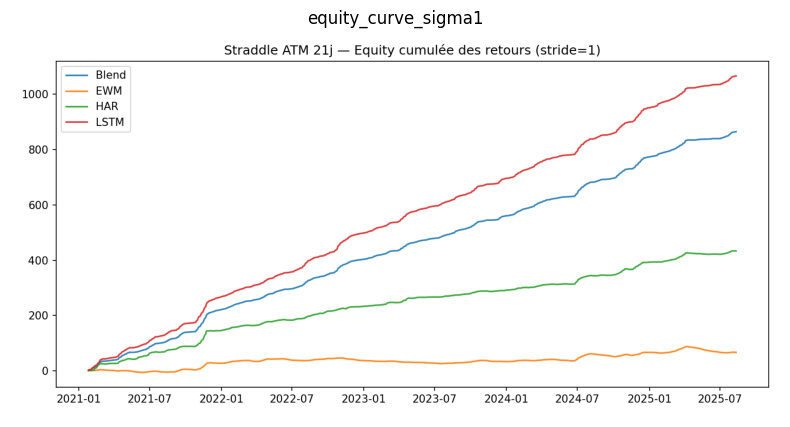

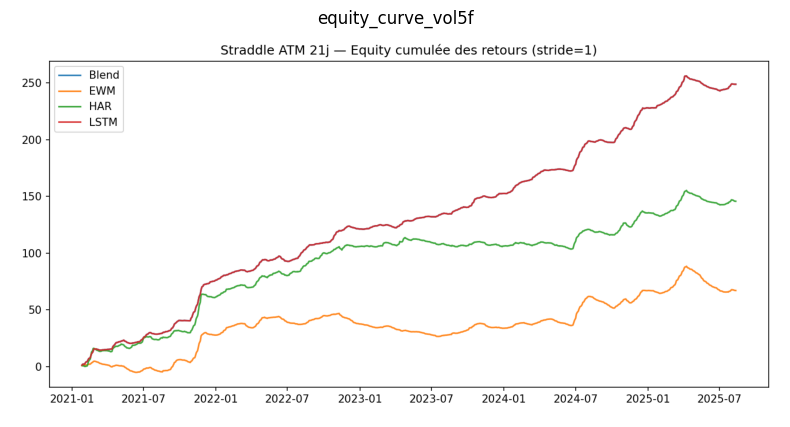

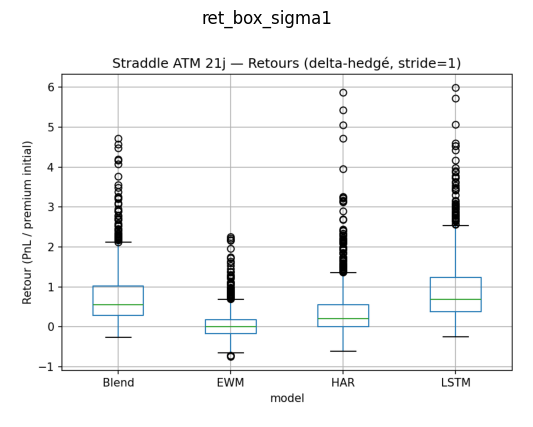

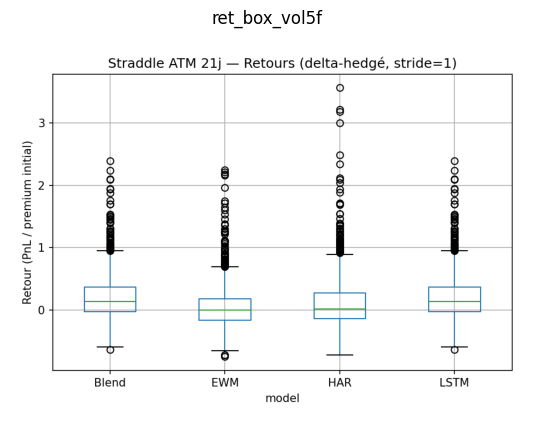

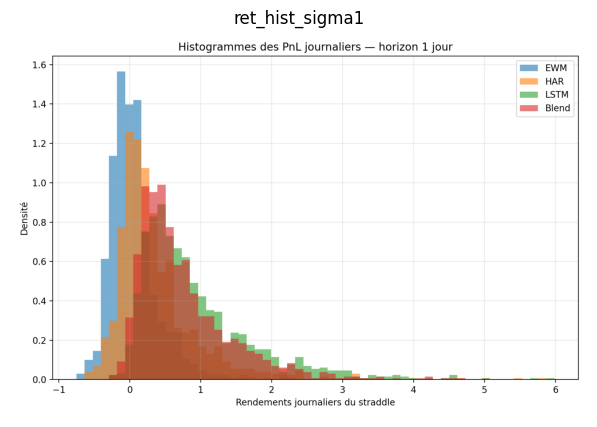

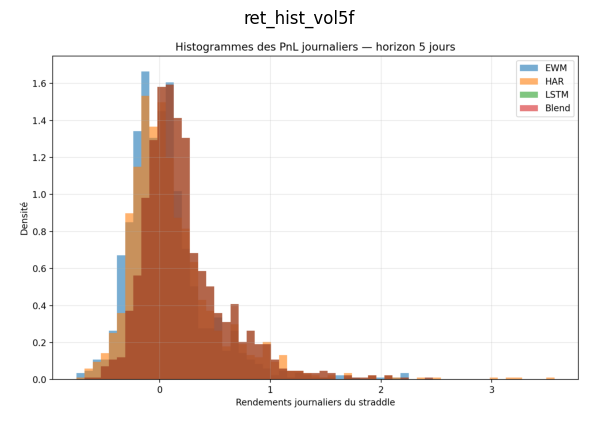

In [33]:
def show_backtest_figures(out_dir="data/backtests/options"):
    """
    Affiche tous les graphiques de backtest (boxplots & equity curves)
    présents dans le dossier de sortie.
    """
    out_dir = Path(out_dir)
    figs = sorted(out_dir.glob("*.png"))
    if not figs:
        print(f"Aucun graphique trouvé dans {out_dir}")
        return
    
    for f in figs:
        img = mpimg.imread(f)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f.stem, fontsize=12)
        plt.show()

# Utilisation :
show_backtest_figures()